Import Primary Modules:

In [5]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from PIL import Image # converting images into arrays

In [6]:
df_can = pd.read_excel('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/Canada.xlsx',
                       sheet_name='Canada by Citizenship',
                       skiprows=range(20),
                       skipfooter=2)
df_can.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,...,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,...,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,...,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,...,0,0,1,1,0,0,0,0,1,1


In [7]:
print(df_can.shape)

(195, 43)


In [8]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis = 1, inplace = True)

# let's rename the columns so that they make sense
df_can.rename (columns = {'OdName':'Country', 'AreaName':'Continent','RegName':'Region'}, inplace = True)

# for sake of consistency, let's also make all column labels of type string
df_can.columns = list(map(str, df_can.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
df_can.set_index('Country', inplace = True)

# add total column
df_can['Total'] =  df_can.sum (axis = 1)

# years that we will be using in this lesson - useful for plotting later on
years = list(map(str, range(1980, 2014)))
print ('data dimensions:', df_can.shape)

data dimensions: (195, 38)


# Visualizing Data using Matplotlib<a id="4"></a>

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

# Waffle Charts <a id="6"></a>

**Case study : Denmark, Norway, and Sweden**

In [15]:
df_dsn = df_can.loc[['Denmark', 'Norway', 'Sweden'], :]
df_dsn

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,Europe,Northern Europe,Developed regions,272,293,299,106,93,73,93,...,62,101,97,108,81,92,93,94,81,3901
Norway,Europe,Northern Europe,Developed regions,116,77,106,51,31,54,56,...,57,53,73,66,75,46,49,53,59,2327
Sweden,Europe,Northern Europe,Developed regions,281,308,222,176,128,158,187,...,205,139,193,165,167,159,134,140,140,5866


Lets create a function called **create_waffle_chart**. This function would take the following parameters as input:

> 1. **categories**: Unique categories or classes in dataframe.
> 2. **values**: Values corresponding to categories or classes.
> 3. **height**: Defined height of waffle chart.
> 4. **width**: Defined width of waffle chart.
> 5. **colormap**: Colormap class
> 6. **value_sign**: In order to make our function more generalizable, we will add this parameter to address signs that could be associated with a value such as %, $, and so on. **value_sign** has a default value of empty string.

In [16]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (df_dsn.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Let's define the input parameters:

In [17]:
width = 40 # width of chart
height = 10 # height of chart

categories = df_dsn.index.values # categories
values = df_dsn['Total'] # correponding values of categories

colormap = plt.cm.coolwarm # color map class

And now let's call our function to create a `waffle` chart.

Total number of tiles is 400
Denmark: 129
Norway: 77
Sweden: 194


<Figure size 432x288 with 0 Axes>

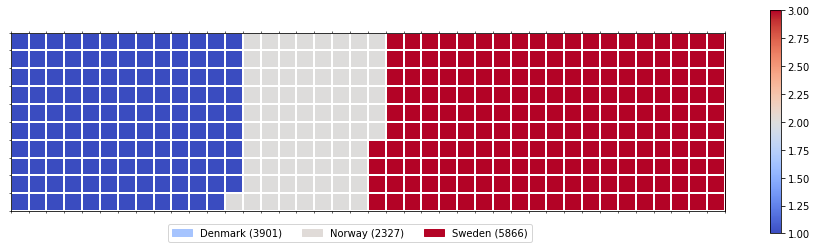

In [26]:
create_waffle_chart(categories, values, height, width, colormap)

# Word Clouds <a id="8"></a>


`Word` clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.

In [27]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

In [32]:
df_can.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15


In [28]:
total_immigration = df_can['Total'].sum()
total_immigration

6409153

Using countries with single-word names, let's duplicate each country's name based on how much they contribute to the total immigration.

In [29]:
max_words = 90
word_string = ''
for country in df_can.index.values:
    # check if country's name is a single-word name
    if len(country.split(' ')) == 1:
        repeat_num_times = int(df_can.loc[country, 'Total']/float(total_immigration)*max_words)
        word_string = word_string + ((country + ' ') * repeat_num_times)
                                     
# display the generated text
word_string

'China China China China China China China China China Colombia Egypt France Guyana Haiti India India India India India India India India India Jamaica Lebanon Morocco Pakistan Pakistan Pakistan Philippines Philippines Philippines Philippines Philippines Philippines Philippines Poland Portugal Romania '

We are not dealing with any stopwords here, so there is no need to pass them when creating the word cloud.

In [30]:
# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

print('Word cloud created!')

Word cloud created!


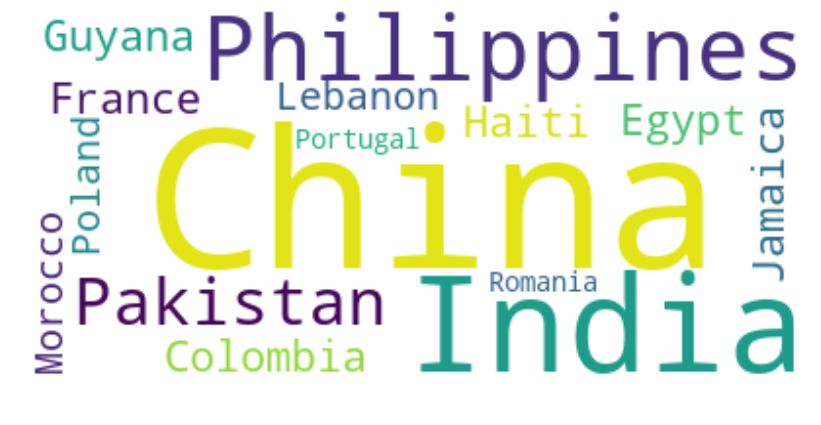

In [31]:
# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

According to the above word cloud, it looks like the majority of the people who immigrated came from one of 15 countries that are displayed by the word cloud.

# Regression Plots <a id="10"></a>

In lab *Pie Charts, Box Plots, Scatter Plots, and Bubble Plots*, we learned how to create a scatter plot and then fit a regression line. It took ~20 lines of code to create the scatter plot along with the regression fit. In this final section, we will explore *seaborn* and see how efficient it is to create regression lines and fits using this library!

Let's first install *seaborn*

In [32]:
# install seaborn
!conda install -c anaconda seaborn --yes

# import library
import seaborn as sns
import pandas as pd

print('Seaborn installed and imported!')

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

Create a new dataframe that stores the total number of landed immigrants to Canada per year from 1980 to 2013.

In [34]:
# we can use the sum() method to get the total population per year
df_tot = pd.DataFrame(df_can[years].sum(axis=0))

# change the years to type float (useful for regression later on)
df_tot.index = map(float, df_tot.index)

# reset the index to put in back in as a column in the df_tot dataframe
df_tot.reset_index(inplace=True)

# rename columns
df_tot.columns = ['year', 'total']

# view the final dataframe
df_tot.head()

,year,total
0,1980.0,99137
1,1981.0,110563
2,1982.0,104271
3,1983.0,75550
4,1984.0,73417


With *seaborn*, generating a regression plot is as simple as calling the **regplot** function.

/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Total Immigration to Canada from 1980 - 2013')

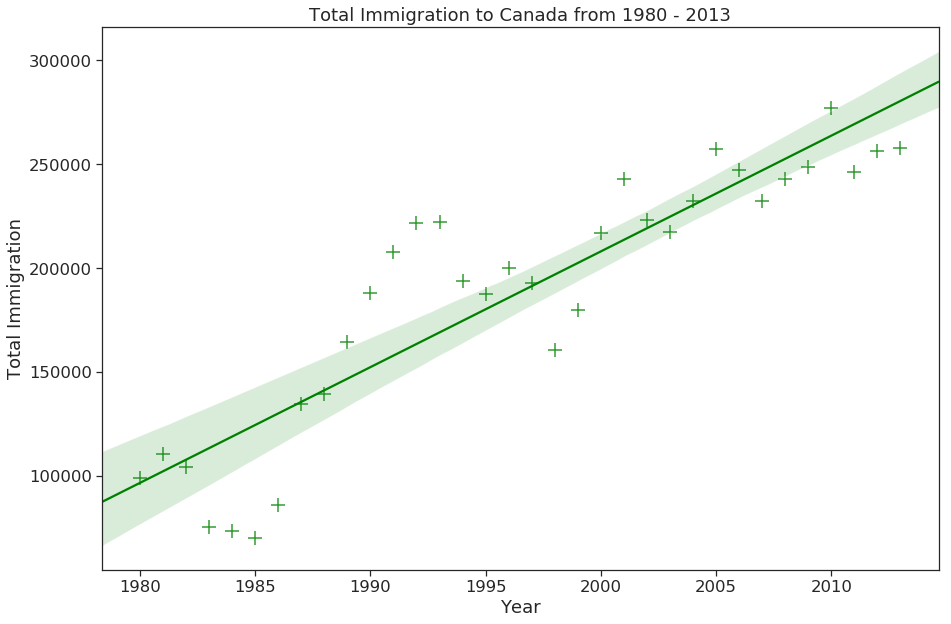

In [35]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('ticks') # change background to white background

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')